In [1]:
import torch 
import torchvision
from torchvision.datasets import CIFAR10
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim import Adam

import numpy
import matplotlib.pyplot as plt
import sys


import IPython

# Loading the data set

* pytorch read the images using PIL
* we have to transform the images to torch tensors using ToTensor()
* we can also normalize the tensors 

##### note:
    - torch uses chanels_first notation (m, n_c, n_w, n_h)

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

###### Downloading the dataset
CIFAR10 is sub-class of **Dataset** 

In [3]:
training_set = CIFAR10("data/",train=True,download=True, transform=transform)
test_set = CIFAR10("data/",train=False,download=True, transform=transform)

Files already downloaded and verified


###### Sampling from the data
**DataLoaders** used to sample from a **Dataset** using a **Sampler**

In [4]:
training_loader = DataLoader(training_set, batch_size=32)
test_loader = DataLoader(test_set, batch_size=32)

**Iterators** used to sample the data

In [5]:
training_data_iterator = iter(training_loader)
test_data_iterator = iter(test_loader)

In [6]:
classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [ ]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(20, 20))
    plt.imshow(numpy.transpose(npimg, (1, 2, 0)))

# Creating the architecture 

**nn.Module**:

- represent a neural network, or any other component (layers.. )
- have a forward pass and a backword pass
- we have to implement the forward pass 
- pytorch and autoGrade handels the bacword pass  

**.cuda()**:

- used to move the component to the GPU
- used on **nn.Module** and on **torch.Tensor**

In [90]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)
        
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.conv3 = nn.Conv2d(32, 64, 3)
        self.fc1 = nn.Linear(64 * 10 * 10, 1024)
        self.fc2 = nn.Linear(1024, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(-1, 64 * 10 * 10)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [91]:
net = Net().cuda()
criterion = nn.CrossEntropyLoss()
optimizer = Adam(net.parameters(), lr=0.001)
history = []

# Training the Model

**Optimizer**:

- **lr**: learning rate 
- **weight_decay**: l2_norm regularizer

**note**:
the optimizer accumilate the grades so we have to use ***optimizer.zero_grad()*** every iteration

we use ***optimizer.step()*** to perform one weight update

In [96]:
# this will run twice
epochs = 10
for epoch in range(epochs):
    epoch_loss = torch.FloatTensor([0])
    for sample_x, sample_y in iter(training_loader):
        x, y = Variable(sample_x.cuda()), Variable(sample_y.cuda())
        
        optimizer.zero_grad()
        
        y_hat = net(x)
        
        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.cpu().data
        sys.stdout.write("\r loss : {:6f}, total epoch loss: {:6f}".format(loss.data[0], epoch_loss[0]))
    
    history.append(epoch_loss[0])    
    print ("\n epoch{} loss: {:6f}".format(epoch +1 , epoch_loss[0]))

 loss : 0.064553, total epoch loss: 169.258057
 epoch1 loss: 169.258057
 loss : 0.002775, total epoch loss: 154.059479
 epoch2 loss: 154.059479
 loss : 0.017421, total epoch loss: 149.386612
 epoch3 loss: 149.386612
 loss : 0.005446, total epoch loss: 136.098404
 epoch4 loss: 136.098404
 loss : 0.071831, total epoch loss: 128.242142
 epoch5 loss: 128.242142
 loss : 0.002068, total epoch loss: 127.268707
 epoch6 loss: 127.268707
 loss : 0.019953, total epoch loss: 106.480797
 epoch7 loss: 106.480797
 loss : 0.020378, total epoch loss: 110.730385
 epoch8 loss: 110.730385
 loss : 0.004514, total epoch loss: 102.912598
 epoch9 loss: 102.912598
 loss : 0.101195, total epoch loss: 96.224869
 epoch10 loss: 96.224869


# ploting the learning curve

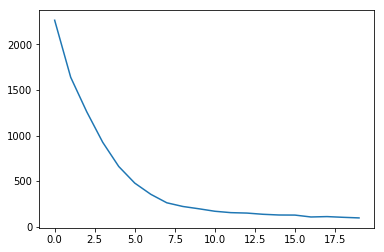

In [99]:
plt.plot(numpy.array(history))

# Testing

In [101]:
dataiter = iter(test_loader)
images, labels = dataiter.next()


imshow(torchvision.utils.make_grid(images))

In [117]:
print(' '.join('%5s' % classes[labels[j]] for j in range(32)))

  cat  ship  ship plane  frog  frog   car  frog   cat   car plane truck   dog horse truck  ship   dog horse  ship  frog horse plane  deer truck   dog  bird  deer plane truck  frog  frog   dog


In [119]:
images_var = Variable(images.cuda())
outputs = net(images_var)

In [120]:
_, predicted = torch.max(outputs.data, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(32)))

Predicted:    cat  ship  ship plane  deer  frog truck  frog   cat   car  bird truck  deer horse truck  ship   dog horse  ship  frog horse  bird plane truck  bird  bird  deer plane truck  frog  frog   dog


In [128]:
correct = 0
total = 0
for data in iter(training_loader):
    images, labels = data
    outputs = net(Variable(images.cuda()))
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels.cuda()).sum()

print('Accuracy of the network on the train images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the train images: 97 %


In [127]:
correct = 0
total = 0
for data in iter(test_loader):
    images, labels = data
    outputs = net(Variable(images.cuda()))
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels.cuda()).sum()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 65 %


### the model is clearly over fitted, the variance is very high

we need to use regularization 

In [19]:
class NetWithDropout(nn.Module):
    def __init__(self):
        super(NetWithDropout, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)
        
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.conv3 = nn.Conv2d(32, 64, 3)
        self.fc1 = nn.Linear(64 * 10 * 10, 1024)
        self.fc2 = nn.Linear(1024, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(-1, 64 * 10 * 10)
        x = F.relu(self.fc1(x))
        x = F.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [20]:
net_with_dropout = NetWithDropout().cuda()
criterion = nn.CrossEntropyLoss()
optimizer = Adam(net_with_dropout.parameters(), lr=0.001)
history = []

In [14]:
epochs = 20
for epoch in range(epochs):
    epoch_loss = torch.FloatTensor([0])
    for sample_x, sample_y in iter(training_loader):
        x, y = Variable(sample_x.cuda()), Variable(sample_y.cuda())
        
        optimizer.zero_grad()
        
        y_hat = net_with_dropout(x)
        
        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.cpu().data
        sys.stdout.write("\r loss : {:6f}, total epoch loss: {:6f}".format(loss.data[0], epoch_loss[0]))
    
    history.append(epoch_loss[0])    
    print ("\n epoch{} loss: {:6f}".format(epoch +1 , epoch_loss[0]))

 loss : 1.794907, total epoch loss: 2253.035156
 epoch1 loss: 2253.035156
 loss : 1.496243, total epoch loss: 1605.981445
 epoch2 loss: 1605.981445
 loss : 1.224754, total epoch loss: 1203.689209
 epoch3 loss: 1203.689209
 loss : 0.658230, total epoch loss: 872.550049
 epoch4 loss: 872.550049
 loss : 0.964605, total epoch loss: 623.819641
 epoch5 loss: 623.819641
 loss : 0.280834, total epoch loss: 442.647278
 epoch6 loss: 442.647278
 loss : 0.060958, total epoch loss: 320.119781
 epoch7 loss: 320.119781
 loss : 0.296577, total epoch loss: 228.378128
 epoch8 loss: 228.378128
 loss : 0.194873, total epoch loss: 203.845047
 epoch9 loss: 203.845047
 loss : 0.003161, total epoch loss: 176.803223
 epoch10 loss: 176.803223
 loss : 0.051296, total epoch loss: 160.239960
 epoch11 loss: 160.239960
 loss : 0.003455, total epoch loss: 142.182648
 epoch12 loss: 142.182648
 loss : 0.161545, total epoch loss: 138.245010
 epoch13 loss: 138.245010
 loss : 0.007262, total epoch loss: 127.032295
 epoch1

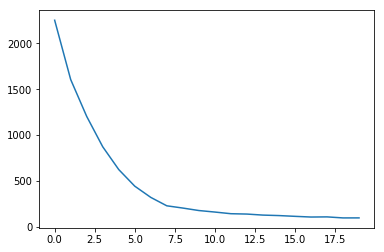

In [15]:
plt.plot(numpy.array(history))

In [17]:
correct = 0
total = 0
for data in iter(training_loader):
    images, labels = data
    outputs = net_with_dropout(Variable(images.cuda()))
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels.cuda()).sum()

print('Accuracy of the network on the train images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the train images: 97 %


In [18]:
correct = 0
total = 0
for data in iter(test_loader):
    images, labels = data
    outputs = net_with_dropout(Variable(images.cuda()))
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels.cuda()).sum()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 66 %


In [31]:
class NetWithDropout(nn.Module):
    def __init__(self):
        super(NetWithDropout, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)
        
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.conv3 = nn.Conv2d(32, 64, 3)
        self.fc1 = nn.Linear(64 * 10 * 10, 1024)
        self.fc2 = nn.Linear(1024, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = F.relu(self.conv2(x))
        x = F.dropout2d(x)
        x = F.relu(self.conv3(x))
        x = x.view(-1, 64 * 10 * 10)
        x = F.relu(self.fc1(x))
        x = F.dropout(x)
        x = F.relu(self.fc2(x))
        x = F.dropout(x)
        x = self.fc3(x)
        return x

In [44]:
loss_history = []
train_history = []
test_history = []
history = []

In [ ]:
net_with_dropout2 = NetWithDropout().cuda()
criterion = nn.CrossEntropyLoss()

In [107]:
optimizer = Adam(net_with_dropout2.parameters(), lr=0.0001, weight_decay=0.005)

In [108]:
epochs = 10
for epoch in range(epochs):
    epoch_loss = torch.FloatTensor([0])
    for sample_x, sample_y in iter(training_loader):
        x, y = Variable(sample_x.cuda()), Variable(sample_y.cuda())
        
        optimizer.zero_grad()
        
        y_hat = net_with_dropout2(x)
        
        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()
        history.append(loss.cpu().data[0])
        epoch_loss += loss.cpu().data
        sys.stdout.write("\rloss : {:6f}, total epoch loss: {:6f}".format(loss.data[0], epoch_loss[0]))
    
    correct = 0
    total = 0
    for data in iter(training_loader):
        images, labels = data
        outputs = net_with_dropout2(Variable(images.cuda()))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.cuda()).sum()
    train_history.append(correct / total)
    
    print('\Accuracy of the network on the train images: %d %%' % (100 * correct / total))
    
    correct = 0
    total = 0
    for data in iter(test_loader):
        images, labels = data
        outputs = net_with_dropout2(Variable(images.cuda()))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.cuda()).sum()
        
    print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))
    test_history.append(correct / total)
    
    loss_history.append(epoch_loss[0])    
    print ("epoch{} loss: {:6f}".format(epoch +1 , epoch_loss[0]))

loss : 1.704743, total epoch loss: 1838.733032\Accuracy of the network on the train images: 59 %
Accuracy of the network on the test images: 58 %
epoch1 loss: 1838.733032
loss : 1.704209, total epoch loss: 1843.080811\Accuracy of the network on the train images: 58 %
Accuracy of the network on the test images: 57 %
epoch2 loss: 1843.080811
loss : 1.704686, total epoch loss: 1852.558350\Accuracy of the network on the train images: 58 %
Accuracy of the network on the test images: 57 %
epoch3 loss: 1852.558350
loss : 1.709072, total epoch loss: 1861.777222\Accuracy of the network on the train images: 58 %
Accuracy of the network on the test images: 57 %
epoch4 loss: 1861.777222
loss : 1.714089, total epoch loss: 1870.565186\Accuracy of the network on the train images: 58 %
Accuracy of the network on the test images: 57 %
epoch5 loss: 1870.565186
loss : 1.716963, total epoch loss: 1878.611084\Accuracy of the network on the train images: 57 %
Accuracy of the network on the test images: 57 %

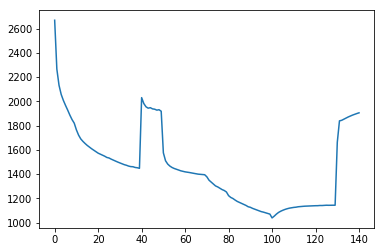

In [109]:
plt.plot(numpy.array(loss_history))

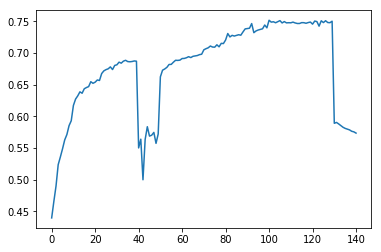

In [110]:
plt.plot(numpy.array(train_history))

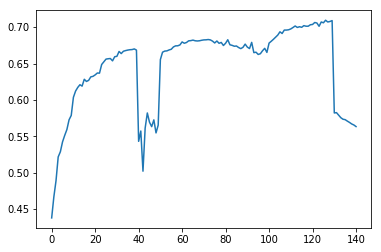

In [111]:
plt.plot(numpy.array(test_history))